In [1]:
import os
os.environ["ROCM_PATH"] = "/opt/rocm"
os.environ["HSA_OVERRIDE_GFX_VERSION"] = "10.3.0"

import numpy as np
import matplotlib.pyplot as plt
import chess
import torch
import math
from utils import *
from chess_net import ChessModel
from parse_data import position_reader
from torch.utils.data import DataLoader
import time

from torch.utils.data.datapipes.iter import IterableWrapper, Shuffler # type: ignore

device = torch.device("cuda" if torch.cuda.is_available else "cpu")

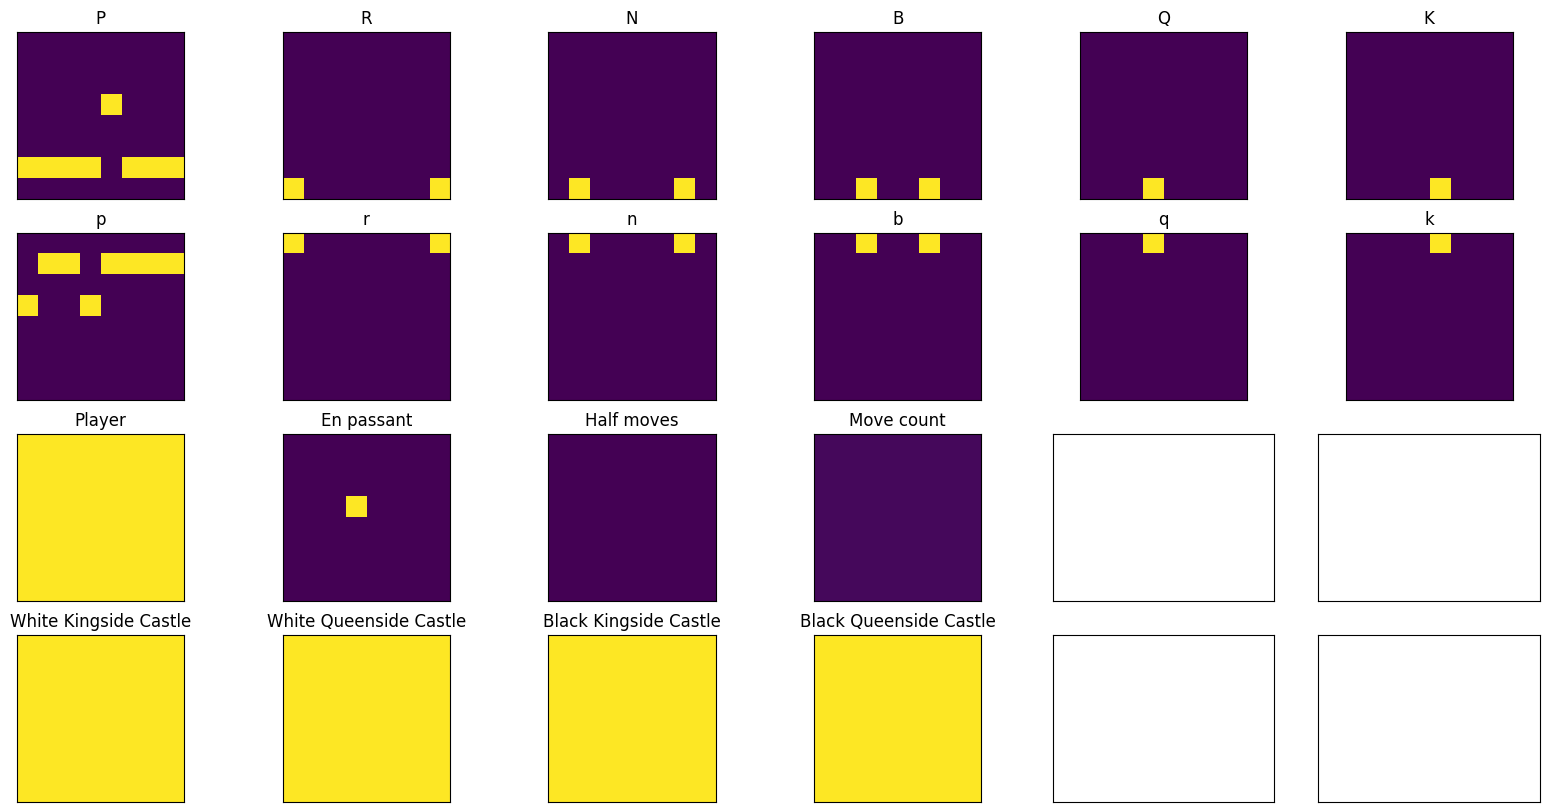

In [2]:
piece_layer = {"P":0,"R":1,"N":2,"B":3,"Q":4, "K":5,"p":6,"r":7,"n":8,"b":9,"q":10, "k":11}

board=chess.Board()
board.push_san("e4")
# board.push_san("Nf6")
board.push_san("a5")
board.push_san("e5")
board.push_san("d5")
board_rep = get_board_rep(board)
fig,axs = plt.subplots(4,6,subplot_kw={"xticks":[], "yticks":[]},figsize=(20,10))
for i in range(2):
    for j in range(6):
        axs[i][j].imshow(board_rep[6*i + j,:,:],vmin=0, vmax=1)
        axs[i][j].set_title(list(piece_layer.keys())[6*i+j])
axs[2][0].imshow(board_rep[12,:,:],vmin=0, vmax=1)
axs[2][0].set_title('Player')
axs[2][1].imshow(board_rep[13,:,:],vmin=0, vmax=1)
axs[2][1].set_title('En passant')
axs[2][2].imshow(board_rep[14,:,:],vmin=0, vmax = 50)
axs[2][2].set_title('Half moves')
axs[2][3].imshow(board_rep[15,:,:],vmin=0, vmax = 150)
axs[2][3].set_title('Move count')
axs[3][0].imshow(board_rep[16,:,:],vmin=0, vmax=1)
axs[3][1].imshow(board_rep[17,:,:],vmin=0, vmax=1)
axs[3][2].imshow(board_rep[18,:,:],vmin=0, vmax=1)
axs[3][3].imshow(board_rep[19,:,:],vmin=0, vmax=1)
axs[3][0].set_title("White Kingside Castle")
axs[3][1].set_title("White Queenside Castle")
axs[3][2].set_title("Black Kingside Castle")
axs[3][3].set_title("Black Queenside Castle")
fig.savefig("img.png")
#0-5 - white pawn/rook/knight/bishop/queen/king
#6-11 same for black
#12 current player's color -> 1 for white
#13 en passant square
#14 half moves since last capture
#15 moves this game
#16-#19 white kingside, white queenside, black kingside, black queenside castling rules

In [3]:
model = ChessModel().to('cuda')

In [4]:
board_rep_tensor = torch.tensor(board_rep).to('cuda')
print(board_rep_tensor.shape)
p, v = model(board_rep_tensor.unsqueeze(0))
print(p.shape, v.shape)
print(p,v)

torch.Size([20, 8, 8])
torch.Size([1, 4864]) torch.Size([1, 1])
tensor([[-0.5022,  0.0988,  0.1940,  ..., -0.5219, -0.3570, -0.1652]],
       device='cuda:0', grad_fn=<AddmmBackward0>) tensor([[0.3644]], device='cuda:0', grad_fn=<TanhBackward0>)


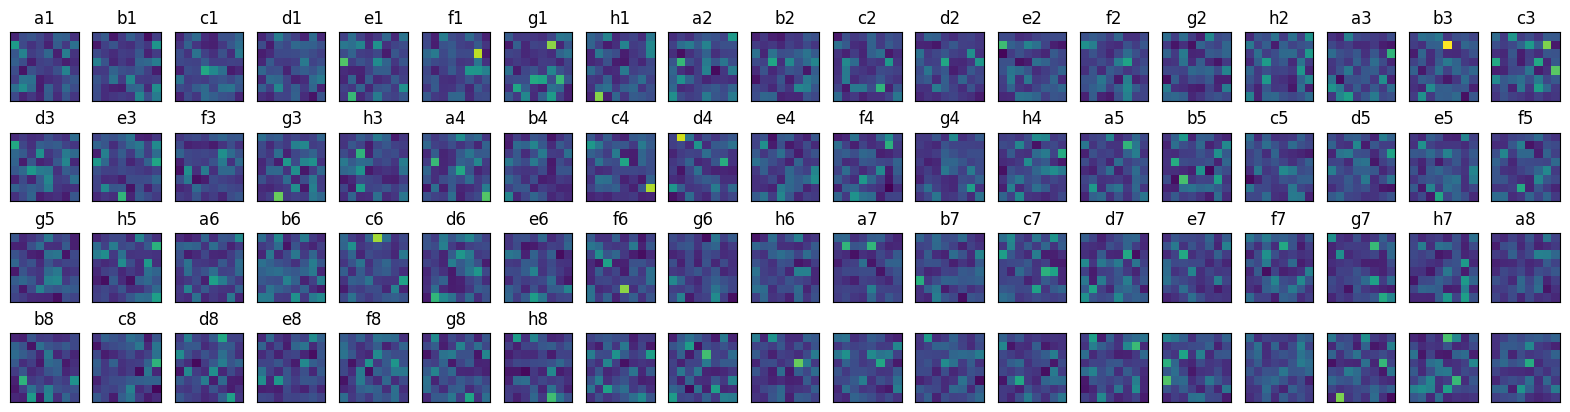

In [5]:
show_move_rep(p)

In [6]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.00025)
policy_loss_fn = torch.nn.CrossEntropyLoss()
value_loss_fn = torch.nn.MSELoss()
epochs, model_path, loss, batch_size, print_counter, save_counter = 5, "model.pt", 0, 4096, 10, 200

In [7]:
training_history = {'loss' : []}

In [ ]:
checkpoint = torch.load("checkpoints/1/checkpoint_1_start.pt")
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
start_epoch = checkpoint['epoch']
print(start_epoch)

1


In [8]:
for epoch in range(2,epochs):
    losses = []
    torch.save({
        'epoch' : epoch,
        'model_state_dict':model.state_dict(),
        'optimizer_state_dict' : optimizer.state_dict(),
    }, f"checkpoints/{epoch}/checkpoint_{epoch}_start.pt")
    print(f"Epoch {epoch} checkpoint saved")
    start_time = time.time()
    data = position_reader("/home/gerard/Documents/Personal/Programming/rl/chess/data/lichess_2013/shortened_data.pgn")
    data = IterableWrapper(data,deepcopy=False)
    data = data.shuffle(buffer_size=batch_size*4)
    data = data.sharding_filter()
    mapped = data.map(get_position_rep)
    loader = DataLoader(dataset=mapped, batch_size=batch_size, num_workers=4,pin_memory=True)
    model.train()
    start_time = time.time()
    for batch, (b,m,r) in enumerate(loader):
        (b,m,r) = (b.to(device),m.to(device),r.to(device))
        (p, v) = model(b.to(device))
        policy_loss = policy_loss_fn(p, m)
        value_loss = value_loss_fn(v, r)
        loss = policy_loss + value_loss
        loss.backward()
        losses.append(loss.item())
        optimizer.step()
        optimizer.zero_grad()
        if (batch+1)%print_counter == 0:
            print(f"policy loss = {policy_loss:.5f}, value_loss = {value_loss:.5f}, batch = {batch+1}, time/10000samples = {(time.time() - start_time)*(10000/(print_counter*batch_size)):.4f}")
            start_time = time.time()
        if (batch+1)%save_counter == 0:
            torch.save({
                'epoch' : epoch,
                'model_state_dict':model.state_dict(),
                'optimizer_state_dict' : optimizer.state_dict(),
            }, f"checkpoints/1/checkpoint_{epoch}_{batch+1}.pt")
    training_history['loss'].append(np.average(losses))
    torch.save({
        'epoch' : epoch,
        'model_state_dict':model.state_dict(),
        'optimizer_state_dict' : optimizer.state_dict(),
    }, f"checkpoints/{epoch}/checkpoint_{epoch}_end.pt")

Epoch 2 checkpoint saved
policy loss = 7.18924, value_loss = 0.95290, batch = 10, time/10000samples = 5.7775
policy loss = 6.43568, value_loss = 0.95170, batch = 20, time/10000samples = 2.5832
Epoch 3 checkpoint saved
policy loss = 6.23028, value_loss = 0.95074, batch = 10, time/10000samples = 6.6994
policy loss = 6.03735, value_loss = 0.95496, batch = 20, time/10000samples = 2.2166
Epoch 4 checkpoint saved
policy loss = 5.94433, value_loss = 0.95993, batch = 10, time/10000samples = 5.6817
policy loss = 5.79175, value_loss = 0.94140, batch = 20, time/10000samples = 2.5058
